# Preprocess dataset
由於此次資料集是有時間相關性的，因此每次預測時使用的特徵包含以下幾項：
1. Movement : 1 為漲 ， 0為不動或跌
2. Volume : 正規化製區間 [0, 1]
3. Close Price : 正規化製區間 [0, 1]
4. Open Price : 正規化製區間 [0, 1]
5. 前5天漲跌 : 1 為漲 ， 0為不動或跌

In [58]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from dateutil.parser import parse

from sklearn import model_selection, preprocessing
import tensorflow as tf
from tqdm import tqdm
import matplotlib.pyplot as plt
from keras import models, layers, optimizers, regularizers
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os

df = pd.read_csv("../input/download.csv", index_col = "Date")

df.index = df.index.to_series().apply(lambda x: parse(str(x)))

#n = len(df.index)

mv = df.iloc[1:]['Close Price'].values - df.iloc[0:-1]['Close Price'].values
df = df[:-1]
df['Movement'] = mv
df['Movement'] = df['Movement'].apply(lambda x: 0 if x <= 0 else 1)

df_h = df[0:-1]
'''
col = []
for i in range(len(df_h.columns)):
    col.append(str(df_h.columns[i]) + '_h')

df = df[1:]
df_h = pd.DataFrame(df_h.values, columns = col, index = df.index)
df_h.head(10)
pd.concat([df, df_h], axis = 1)
'''
n = len(df.index)
index = df.index
feature = []
day_windows = 5
for i in range(day_windows, n):
    feature.append(df.iloc[i-day_windows:i]['Movement'].values.tolist())

feature_sel = ['Movement', 'Volume', 'Close Price', 'Open Price']
df = pd.concat([pd.DataFrame(df[feature_sel].values[day_windows:], columns = feature_sel), pd.DataFrame(feature)], axis = 1)
df.index = index[day_windows:]
#df = df.rename(columns={day_windows-1:'Movement'})
for i in range(0, day_windows):
    df[i] = df[i] * (i + 1) / day_windows
df
# Any results you write to the current directory are saved as output.

,Movement,Volume,Close Price,Open Price,0,1,2,3,4
Date,,,,,,,,,
2009-01-09,0.0,4.716500e+09,890.35,909.91,0.0,0.4,0.0,0.8,0.0
2009-01-12,1.0,4.725050e+09,870.26,890.40,0.2,0.0,0.6,0.0,0.0
2009-01-13,0.0,5.017470e+09,871.79,869.79,0.0,0.4,0.0,0.0,1.0
2009-01-14,1.0,5.407880e+09,842.62,867.28,0.2,0.0,0.0,0.8,0.0
2009-01-15,1.0,7.807350e+09,843.74,841.99,0.0,0.0,0.6,0.0,1.0
2009-01-16,0.0,6.786040e+09,850.12,844.45,0.0,0.4,0.0,0.8,1.0
2009-01-20,1.0,6.375230e+09,805.22,849.64,0.2,0.0,0.6,0.8,0.0
2009-01-21,0.0,6.467830e+09,840.24,806.77,0.0,0.4,0.6,0.0,1.0
2009-01-22,1.0,5.843830e+09,827.50,839.74,0.2,0.4,0.0,0.8,0.0


In [59]:
feature_sel.remove('Movement')
feature_sel

['Volume', 'Close Price', 'Open Price']

# Preprocess Done !

In [60]:
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

X = df.loc[:, df.columns != "Movement"]
Y = df["Movement"]

sc = MinMaxScaler(feature_range=(0,1))
X.loc[:, feature_sel] = sc.fit_transform(X.loc[:, feature_sel])
X

/opt/conda/lib/python3.6/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


,Volume,Close Price,Open Price,0,1,2,3,4
Date,,,,,,,,
2009-01-09,0.488069,0.094853,0.102163,0.0,0.4,0.0,0.8,0.0
2009-01-12,0.489063,0.085941,0.093520,0.2,0.0,0.6,0.0,0.0
2009-01-13,0.523058,0.086620,0.084391,0.0,0.4,0.0,0.0,1.0
2009-01-14,0.568444,0.073680,0.083279,0.2,0.0,0.0,0.8,0.0
2009-01-15,0.847389,0.074176,0.072076,0.0,0.0,0.6,0.0,1.0
2009-01-16,0.728659,0.077007,0.073166,0.0,0.4,0.0,0.8,1.0
2009-01-20,0.680901,0.057088,0.075465,0.2,0.0,0.6,0.8,0.0
2009-01-21,0.691666,0.072624,0.056474,0.0,0.4,0.6,0.0,1.0
2009-01-22,0.619124,0.066972,0.071079,0.2,0.4,0.0,0.8,0.0


# SVM

In [61]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

#X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.25, random_state = 0)

X_train = X[:'2017']
y_train = Y[:'2017']
X_test = X['2018':]
y_test = Y['2018':]

penalty = 0.05

svm = SVC(C=penalty, kernel="linear", probability=True)
svm.fit(X_train, y_train)
  
svm.score(X_test,y_test)

0.5219123505976095

In [62]:
svm.predict(X_test)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1.

# Simple NN

Epoch 1/10
2259/2259 [==============================] - 1s 632us/step - loss: 0.6937 - acc: 0.5361
Epoch 2/10
2259/2259 [==============================] - 0s 67us/step - loss: 0.6911 - acc: 0.5343
Epoch 3/10
2259/2259 [==============================] - 0s 72us/step - loss: 0.6939 - acc: 0.5277
Epoch 4/10
2259/2259 [==============================] - 0s 59us/step - loss: 0.6902 - acc: 0.5432
Epoch 5/10
2259/2259 [==============================] - 0s 59us/step - loss: 0.6913 - acc: 0.5378
Epoch 6/10
2259/2259 [==============================] - 0s 57us/step - loss: 0.6893 - acc: 0.5352
Epoch 7/10
2259/2259 [==============================] - 0s 46us/step - loss: 0.6904 - acc: 0.5467
Epoch 8/10
2259/2259 [==============================] - 0s 45us/step - loss: 0.6925 - acc: 0.5299
Epoch 9/10
2259/2259 [==============================] - 0s 44us/step - loss: 0.6909 - acc: 0.5467
Epoch 10/10
251/251 [==============================] - 0s 28us/step
Training accuracy: 0.5467020807249349
Testing acc

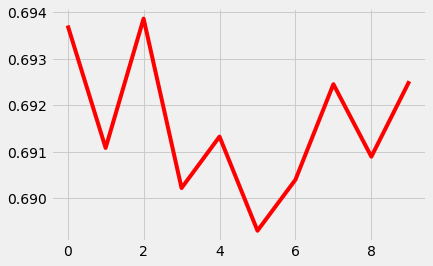

In [63]:
x_train = preprocessing.normalize(X_train)
x_test = preprocessing.normalize(X_test)

hidden_units = x_train.shape[1]    # how many neurons in the hidden layer
activation = 'relu'  # activation function for hidden layer
l2 = 0.001           # regularization - how much we penalize large parameter values
learning_rate = 0.1  # how big our steps are in gradient descent
epochs = 20          # how many epochs to train for
batch_size = 250     # how many samples to use for each gradient descent update

# create a sequential model
model = models.Sequential()

# add the hidden layer
model.add(layers.Dense(input_dim=x_train.shape[1],
                       units=hidden_units, 
                       activation=activation))

# add the output layer
model.add(layers.Dense(input_dim=hidden_units,
                       units=1,
                       activation='sigmoid'))

# define our loss function and optimizer
model.compile(loss='binary_crossentropy',
              # Adam is a kind of gradient descent
              optimizer=optimizers.Adam(lr=learning_rate),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=10, batch_size=32)

# evaluate accuracy
train_acc = model.evaluate(x_train, y_train, batch_size=32)[1]
test_acc = model.evaluate(x_test, y_test, batch_size=32)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.show()

In [64]:
model.predict(x_test)

array([[0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],
       [0.546445 ],


# Logistic Regression

In [65]:
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing

lgr = LogisticRegression()
lgr.fit(X_train, y_train)

lgr.score(X_test, y_test)

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.545816733067729

In [66]:
lgr.predict(X_test)

array([0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1.,
       1., 0., 1., 0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
       1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 0., 1., 1., 1.

# Another try - RNN(LSTM units)

1. 使用基於LSTM units的RNN Model去預測股市價格，最後再藉由(預測的價格) - (昨天預測的價格) 取得漲跌預測結果

2. 40 Features : 將過去40天的 Close Price 當作feature

3. Train data : 2009 - 2017 years

4. Test data : 2018 year

In [67]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, GRU, Bidirectional
from keras.optimizers import SGD
import math
from sklearn.metrics import mean_squared_error

In [68]:
# Some functions to help out with
def plot_predictions(test,predicted):
    plt.plot(test, color='red',label='Real Stock Price')
    plt.plot(predicted, color='blue',label='Predicted Stock Price')
    plt.xlabel('Time')
    plt.ylabel('Stock Price')
    plt.legend()
    plt.show()

def return_rmse(test,predicted):
    rmse = math.sqrt(mean_squared_error(test, predicted))
    print("The root mean squared error is {}.".format(rmse))

In [69]:
dataset = pd.read_csv('../input/download.csv', index_col='Date', parse_dates=['Date'])
dataset.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2009-01-02 to 2018-12-31
Data columns (total 5 columns):
Open Price     2516 non-null float64
Close Price    2516 non-null float64
High Price     2516 non-null float64
Low Price      2516 non-null float64
Volume         2516 non-null int64
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


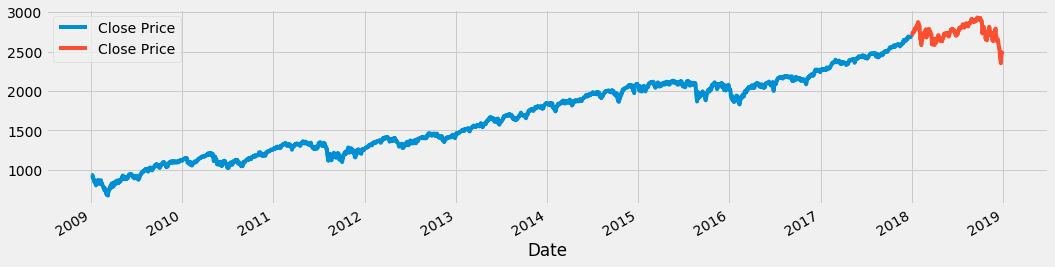

In [70]:
features = 40

training_set = dataset[:'2017']["Close Price"].values
test_set = dataset['2018':]["Close Price"].values

dataset[:'2017']["Close Price"].plot(figsize=(16,4),legend=True)
dataset['2018':]["Close Price"].plot(figsize=(16,4),legend=True)

In [71]:
# Scaling the training set
sc = MinMaxScaler(feature_range=(0,1))
training_set_scaled = sc.fit_transform(training_set.reshape(-1, 1))

X_train = []
y_train = []
for i in range(features,training_set_scaled.shape[0]):
    X_train.append(training_set_scaled[i-features:i,0])
    y_train.append(training_set_scaled[i,0])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train.shape

(2224, 40)

In [72]:
# Reshaping X_train for efficient modelling
X_train = np.reshape(X_train, (X_train.shape[0],X_train.shape[1],1))

# Model

兩層LSTM 後接著 Dropout，最後接上一層 Dense layer 獲取預測價格

In [73]:
units = 5
# The LSTM architecture
regressor = Sequential()
# First LSTM layer with Dropout regularisation
regressor.add(LSTM(units=units+200, return_sequences=True, input_shape=(X_train.shape[1],1)))
regressor.add(Dropout(0.2))
# Second LSTM layer
#regressor.add(LSTM(units=units, return_sequences=True))
#regressor.add(Dropout(0.2))
# Third LSTM layer
#regressor.add(LSTM(units=units, return_sequences=True))
#regressor.add(Dropout(0.2))
# Fourth LSTM layer
regressor.add(LSTM(units=units))
regressor.add(Dropout(0.2))
# The output layer
regressor.add(Dense(units=1))

# Compiling the RNN
regressor.compile(optimizer='rmsprop',loss='mean_squared_error')
# Fitting to the training set
regressor.fit(X_train,y_train,epochs=100,batch_size=32)

Epoch 1/100
2224/2224 [==============================] - 7s 3ms/step - loss: 0.0409
Epoch 2/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0154
Epoch 3/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0126
Epoch 4/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0103
Epoch 5/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0093
Epoch 6/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0079
Epoch 7/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0068
Epoch 8/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0063
Epoch 9/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0051
Epoch 10/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0051
Epoch 11/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0044
Epoch 12/100
2224/2224 [==============================] - 4s 2ms/step - lo

2224/2224 [==============================] - 4s 2ms/step - loss: 0.0029
Epoch 98/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0031
Epoch 99/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0028
Epoch 100/100
2224/2224 [==============================] - 4s 2ms/step - loss: 0.0031


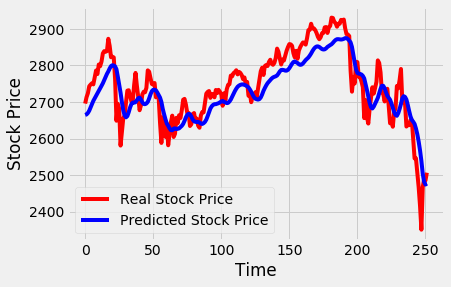

The root mean squared error is 52.1616776271615.


In [74]:
inputs = dataset[len(dataset)-len(test_set) - features:]["Close Price"].values
inputs = inputs.reshape(-1,1)
inputs  = sc.transform(inputs)

# Preparing X_test and predicting the prices
X_test = []
for i in range(features,inputs.shape[0]):
    X_test.append(inputs[i-features:i,0])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0],X_test.shape[1],1))

predicted_stock_price = regressor.predict(X_test)
predicted_stock_price = sc.inverse_transform(predicted_stock_price)

# Visualizing the results for LSTM
plot_predictions(test_set,predicted_stock_price)

return_rmse(test_set,predicted_stock_price)

In [75]:
def mv_accuracy(test, predicted):
    correct_num = 0
    for i in range(0, len(test)):
        correct_num += 1 if test[i] == predicted[i] else 0
    print('Accuracy:', correct_num / len(test) * 100)
    return

In [76]:
test_mv = [1 if test_set[0] - training_set[-1] > 0 else 0]
predicted_mv = [1 if predicted_stock_price[0] - training_set[-1] > 0 else 0]
for i in range(1, len(test_set)):
    test_mv.append(1 if test_set[i] - test_set[i-1] > 0 else 0)
    predicted_mv.append(1 if predicted_stock_price[i] - predicted_stock_price[i-1] > 0 else 0)
    
mv_accuracy(test_mv, predicted_mv)

Accuracy: 50.79365079365079


# Conclusion

* Baseline : Random choice -->  50% Accuracy

* SVM --> 52%
* Simple NN --> 52%
* Logistic Regression --> 55%
* RNN(LSTM) --> 51%

-------------------------------------------------------------------------
1. 對於上述SVM 、 Simple NN 、 Logistic Regression 不論是否有納入前幾天漲跌資訊當作特徵，對於結果並無太大影響

2. Logistic Regression 相比 SVM 、 Simple NN 有更好的預測性，而非單單預測 1

3. 可以看出LSTM base 的 RNN Model 對於 Test data的Close Price 價格有不錯的預測結果，但將其兩兩相減後轉換成預測漲跌(1 or 0)時，預測漲跌卻只有51%的正確率，我認為原因可能為短期漲跌起伏差異太大，僅僅從此Dataset中所獲得的特徵無法確實涵蓋真正的漲跌預測函式f